In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

In [39]:
df = pd.read_csv('H:\\Coding\\MFT Courses\\Machine Learning\\spambase.csv')

df.head(5)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [40]:
duplicated_rows = df.duplicated()
num_duplicate_rows = sum(duplicated_rows)
print(f"Number of duplicate rows: {num_duplicate_rows}")

Number of duplicate rows: 391


In [41]:
df = df.drop_duplicates()


<Axes: >

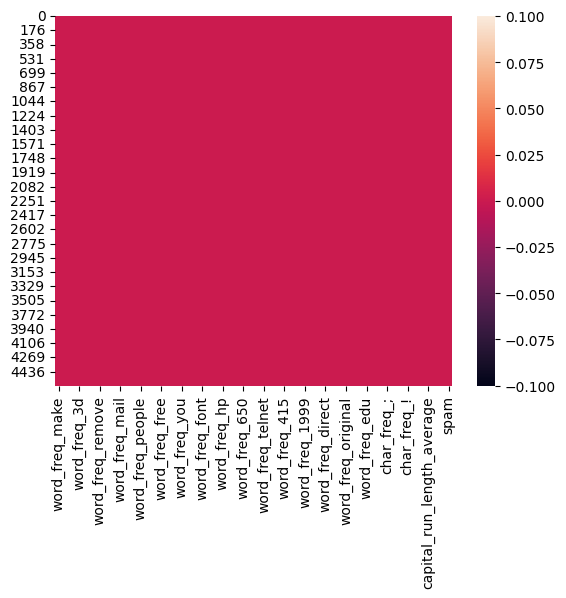

In [42]:
sns.heatmap(df.isnull())

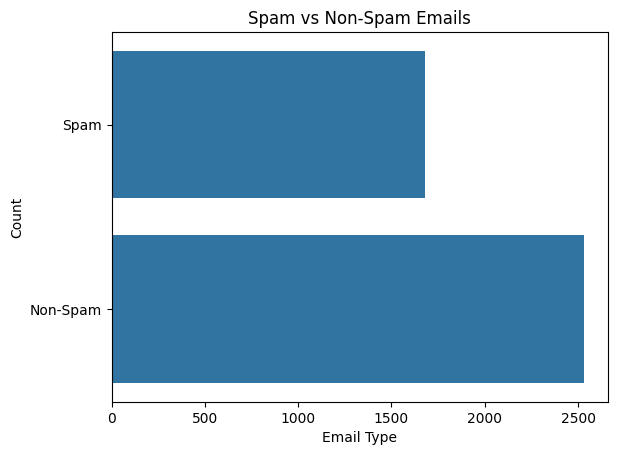

In [43]:
#countplot of spam vs ham
df['spam_label'] = df['spam'].map({0: 'Non-Spam', 1: 'Spam'})

# distribution plot of spam vs non-spam emails
sns.countplot(df['spam_label'])
plt.title("Spam vs Non-Spam Emails")
plt.xlabel("Email Type")
plt.ylabel("Count")
plt.show()

In [44]:
X = df.drop(['spam', 'spam_label'], axis = 1).values
y = df['spam'].values

In [45]:
#data split into labeled and unlabeled
X_labeled, X_unlabeled, y_labeled, _ = train_test_split(X, y, test_size=0.7, stratify=y) 


In [46]:
#parameters 

ensemble_size = 100              # Number of classifiers in the ensemble
iterations = 5  
batch_size = 5                  # Number of unlabeled samples to add in each iteration
unlabeled_fraction = 0.35       # Fraction of unlabeled data to use for self-training
oob_threshold = 0.05            # Early stopping threshold for OOB error

In [47]:
# standarization, feature selection

scaler = MinMaxScaler()
feature_selector = SelectFromModel(estimator=RandomForestClassifier(n_estimators=50, random_state=1403))

new_Xlabel = feature_selector.fit_transform(scaler.fit_transform(X_labeled), y_labeled)
new_X_unlabeled = feature_selector.transform(scaler.transform(X_unlabeled))


In [48]:
pipeline = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=4), 
    n_estimators=ensemble_size, 
    oob_score=True, 
    random_state=1403
)

In [49]:
# self training

for iteration in range(iterations):
    print(f"\nIteration {iteration + 1} started:")
    
    pipeline.fit(new_Xlabel, y_labeled)                               # (1) pipeline training on labeled data

    
    y_probs = pipeline.predict_proba(new_X_unlabeled)                # (2) probability prediction for UNlabeled data
    
   
    confidence_scores = np.max(y_probs, axis=1)                      # (3)  selecting top confident samples based on probability
    confident_samples = np.argsort(confidence_scores)[-batch_size:]  # wE have most confident predictions
    
    X_confident = new_X_unlabeled[confident_samples]                # Confident unlabeled samples
    y_confident = np.argmax(y_probs[confident_samples], axis=1)     # their labels
    
    
    new_Xlabel = np.vstack((new_Xlabel, X_confident))           # (4) Adding confident samples to the labeled data
    y_labeled = np.hstack((y_labeled, y_confident))             # now, adding new confident labels to labeled labels
    
    # Debugging: Print the size of the labeled dataset after augmentation
    #print(f"After adding confident samples: X_labeled_transformed: {new_Xlabel.shape}, y_labeled: {y_labeled.shape}")

    new_X_unlabeled = np.delete(new_X_unlabeled, confident_samples, axis=0)     # (5) delecting confident samples from the unlabeled data          
    
    
    if len(new_X_unlabeled) == 0:                                      ## Stop if no more unlabeled data
        print("All unlabeled data are labeled, so stopping self-training.")
        break
    
    pipeline.fit(new_Xlabel, y_labeled)                         #  again, training Bagging Classifier with the updated labeled data

    oob_error = 1 - pipeline.oob_score_                         # (6) calculating OOB error
    print(oob_error)
    
    if oob_error < oob_threshold:                               # (7) early stopping based on OOB error
        print("Early stopping cuz of low OOB error.")
        break


Iteration 1 started:
0.09069400630914826

Iteration 2 started:
0.0911233307148468

Iteration 3 started:
0.09076682316118934

Iteration 4 started:
0.0904130943102105

Iteration 5 started:
0.09239130434782605


In [50]:
# Performance Evaluation

X_test = X  # full dataset as test data
y_test = y

In [51]:
X_test_transformed = feature_selector.transform(scaler.transform(X_test))
y_pred = pipeline.predict(X_test_transformed)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      2531
           1       0.93      0.82      0.87      1679

    accuracy                           0.90      4210
   macro avg       0.91      0.89      0.90      4210
weighted avg       0.91      0.90      0.90      4210

